# KMeans clustering for Football Analysis

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import missingno as msno 
from statsbombpy import sb
from mplsoccer.pitch import Pitch
from sklearn.cluster import KMeans
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Belgium v Italy EURO 2020

In [21]:
s = sb.events(22912)

credentials were not supplied. open data access only


In [22]:
s.columns

Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_other', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_offensive', 'foul_committed_penalty',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_punched_out', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'interception_outcome', 'location',
       'match_id', 'minute', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected

In [3]:
matches = sb.matches(55,43)

credentials were not supplied. open data access only


In [4]:
belgium = matches[(matches['home_team'] == 'Belgium') | (matches['away_team'] == 'Belgium')]

In [5]:
belgium

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,data_version,shot_fidelity_version,xy_fidelity_version
2,3795107,2021-07-02,21:00:00.000,Europe - UEFA Euro,2020,Belgium,Italy,1,2,available,available,2021-07-19T12:41:55.898,2021-09-23T00:02:51.495862,5,Quarter-finals,Allianz Arena (München),Slavko Vinčić,1.1.0,2,2
8,3794687,2021-06-27,21:00:00.000,Europe - UEFA Euro,2020,Belgium,Portugal,1,0,available,available,2021-07-05T13:37:21.633,2021-09-22T16:40:48.020474,4,Round of 16,Estadio Olímpico de Sevilla (Sevilla),Felix Brych,1.1.0,2,2
13,3788768,2021-06-21,21:00:00.000,Europe - UEFA Euro,2020,Finland,Belgium,0,2,available,available,2021-06-22T13:47:34.925,2021-09-22T16:40:14.297313,3,Group Stage,Saint-Petersburg Stadium,Felix Brych,1.1.0,2,2
18,3788757,2021-06-17,18:00:00.000,Europe - UEFA Euro,2020,Denmark,Belgium,1,2,available,available,2021-07-24T16:17:22.251,2021-09-22T16:39:19.238605,2,Group Stage,Nya Parken,Björn Kuipers,1.1.0,2,2
49,3788743,2021-06-12,21:00:00.000,Europe - UEFA Euro,2020,Belgium,Russia,3,0,available,available,2021-06-13T13:10:11.602,2021-09-22T16:38:15.368959,1,Group Stage,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz,1.1.0,2,2


In [6]:
event = sb.events(3795107)

credentials were not supplied. open data access only


### Get the passes

In [7]:
df = event[['team', 'type', 'location', 'pass_end_location']]

In [8]:
be = df[(df['team'] == 'Belgium') & (df['type'] == 'Pass')]

In [9]:
def get_passes(df):
    df['x'] = [i[0] for i in df['location'].values]
    df['y'] = [i[1] for i in df['location'].values]
    df['endX'] = [i[0] for i in df['pass_end_location'].values]
    df['endY'] = [i[1] for i in df['pass_end_location'].values]
    df = df.drop(['location', 'pass_end_location'], axis =1)
    return df

In [10]:
be = get_passes(be)

In [11]:
be

,team,type,x,y,endX,endY
6,Belgium,Pass,60.0,40.0,54.2,36.3
7,Belgium,Pass,51.4,33.7,34.1,17.5
8,Belgium,Pass,33.0,14.7,41.1,1.6
9,Belgium,Pass,37.1,2.3,5.4,30.9
10,Belgium,Pass,7.5,32.2,9.5,51.3
...,...,...,...,...,...,...
1029,Belgium,Pass,97.8,22.0,95.6,52.9
1030,Belgium,Pass,96.6,55.2,115.5,60.7
1031,Belgium,Pass,115.8,60.7,113.5,48.2
1032,Belgium,Pass,120.0,80.0,113.8,51.4


In [10]:
#create variable X and fit it
#from sklearn.cluster import KMeans
X = np.array(be[['x','y','endX', 'endY']])
kmeans = KMeans(n_clusters = 10, random_state=42)
kmeans.fit(X)
be['cluster'] = kmeans.predict(X)

__WSS__ : The sum distance within the centroids. Since the K-means algorithm's goal is to keep the size of each cluster as small as possible, the small wss indicates that every data point is close to its nearest centroids, or say the model has returned good results.

In [25]:
#elbow method
K = range(1,50)
wss= []
for k in K:
    array = np.array(be[['x', 'y', 'endX', 'endY']])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(array)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
mycenters = pd.DataFrame({'Clusters':K, 'WSS':wss})
mycenters

,Clusters,WSS
0,1,1.504682e+06
1,2,9.099047e+05
2,3,6.742809e+05
3,4,5.124865e+05
4,5,4.319677e+05
5,6,3.774535e+05
6,7,3.451678e+05
7,8,3.189682e+05
8,9,2.921212e+05
9,10,2.741218e+05


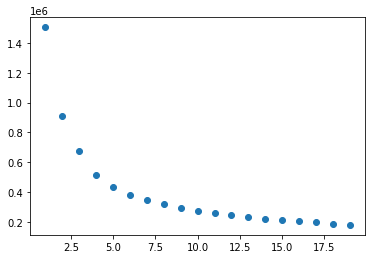

In [17]:
plt.scatter(x=mycenters['Clusters'], y=mycenters['WSS'])

<AxesSubplot:>

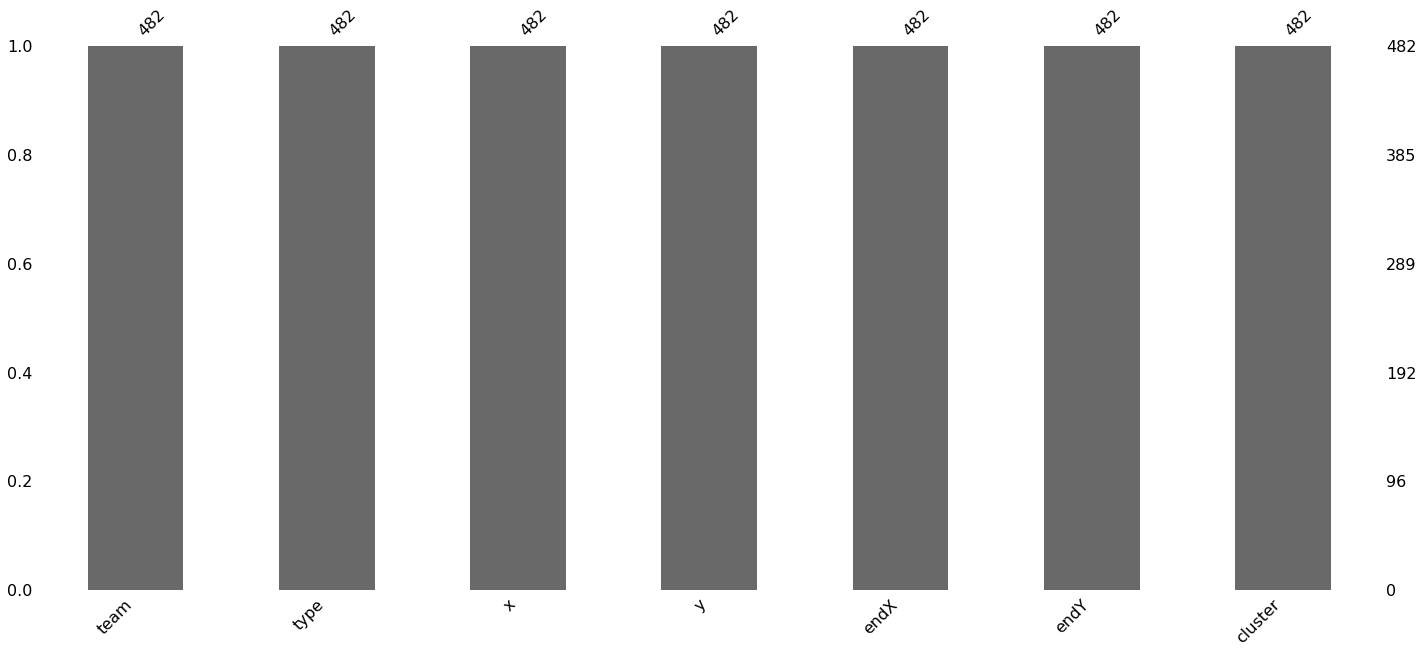

In [11]:
msno.bar(be)

In [12]:
be.cluster.value_counts()

5    58
6    57
1    56
2    56
3    51
4    47
9    44
8    39
7    38
0    36
Name: cluster, dtype: int64

In [13]:
import matplotlib
i = 0 
for cname, hex in matplotlib.colors.cnames.items():
    print(cname,hex)
    i += 1
    if i >100:
        break

aliceblue #F0F8FF
antiquewhite #FAEBD7
aqua #00FFFF
aquamarine #7FFFD4
azure #F0FFFF
beige #F5F5DC
bisque #FFE4C4
black #000000
blanchedalmond #FFEBCD
blue #0000FF
blueviolet #8A2BE2
brown #A52A2A
burlywood #DEB887
cadetblue #5F9EA0
chartreuse #7FFF00
chocolate #D2691E
coral #FF7F50
cornflowerblue #6495ED
cornsilk #FFF8DC
crimson #DC143C
cyan #00FFFF
darkblue #00008B
darkcyan #008B8B
darkgoldenrod #B8860B
darkgray #A9A9A9
darkgreen #006400
darkgrey #A9A9A9
darkkhaki #BDB76B
darkmagenta #8B008B
darkolivegreen #556B2F
darkorange #FF8C00
darkorchid #9932CC
darkred #8B0000
darksalmon #E9967A
darkseagreen #8FBC8F
darkslateblue #483D8B
darkslategray #2F4F4F
darkslategrey #2F4F4F
darkturquoise #00CED1
darkviolet #9400D3
deeppink #FF1493
deepskyblue #00BFFF
dimgray #696969
dimgrey #696969
dodgerblue #1E90FF
firebrick #B22222
floralwhite #FFFAF0
forestgreen #228B22
fuchsia #FF00FF
gainsboro #DCDCDC
ghostwhite #F8F8FF
gold #FFD700
goldenrod #DAA520
gray #808080
green #008000
greenyellow #ADFF2F


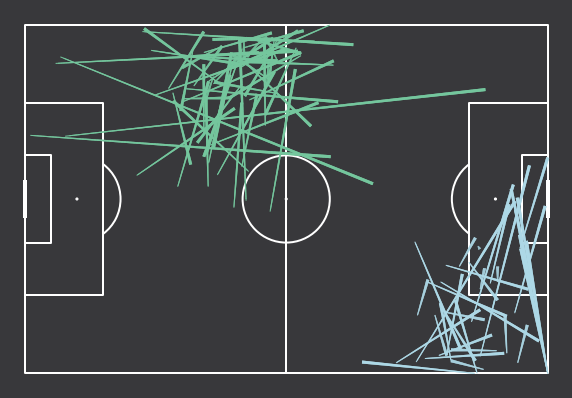

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor('#38383b')
ax.patch.set_facecolor('#38383b')

pitch = Pitch(orientation='horizontal', pitch_color = '#38383b', line_color = 'white', figsize = (10,10),
             constrained_layout=False, tight_layout=True, view='full')

pitch.draw(ax=ax)

for row in range(len(be['cluster'])):
    
    if be['cluster'].values[row] == 5: #the location of passes from where Belgium made most of their passes
        pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
                yend=be['endY'].values[row],color='#74c69d', lw=3, zorder=2, comet=True, ax=ax)
        
    if be['cluster'].values[row] == 0: #the location of passes from where Belgium made least of their passes
        pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
                yend=be['endY'].values[row],color='#add8e6', lw=3, zorder=2, comet=True, ax=ax)
        
#     if be['cluster'].values[row] == 6: #the location of passes from where Belgium made the second least of their passes
#         pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
#             yend=be['endY'].values[row],color='#FFEBCD', lw=3, zorder=2, comet=True, ax=ax)
        
#     if be['cluster'].values[row] == 7: #the location of passes from where Belgium made the second most of their passes
#         pitch.lines(xstart=be['x'].values[row], ystart=be['y'].values[row], xend=be['endX'].values[row],
#             yend=be['endY'].values[row],color='#A52A2A', lw=3, zorder=2, comet=True, ax=ax)
        
